# Air Quality Index Prediction

### Problem Statement

Air pollution is being measured by AQI (Air Quality Index) and higher the AQI higher the air pollution. In this project we will analyze the air quality data of major developing cities in India to find some or patterns which will help us in predicting the AQI with the given data. Since this data has been captured at specific intervals over a period of time we will be conducting a various Analysis to predict the AQI of a city at a point in time.

### Importing Libraries that are useful for data manipulation and visualization

In [1]:
# For data reading | manipulation :
import pandas as pd 

#For handling spatial data
import geopandas as gpd

#import psycopg2 library to connect database :
import psycopg2

# For reading the array :
import numpy as np

# For visualize the data and plotting  :
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]
import seaborn as sns

# To ignore warnings :
from warnings import filterwarnings
filterwarnings('ignore')

# Train-test split :
from sklearn.model_selection import train_test_split

#import LinearRegression from sklearn library
from sklearn.linear_model import LinearRegression 

#import RandomForestRegressor from sklearn library
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor

# To check the accuracy of model :
from sklearn.metrics import r2_score,mean_absolute_error 

# Import 'stats' libraries for modeling :
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import OLS

# To scaled the data :
from sklearn.preprocessing import StandardScaler



### Load and Read the Data from Database

In [3]:
#create a connection object
connection=psycopg2.connect(database="library",user="postgres",password="snag2568")

#create a cursor
cursor=connection.cursor()
connection.commit()
AQI_city_day=pd.read_sql("SELECT * FROM raw_data",con=connection)


In [4]:
# Read the data :
AQI_city_day=pd.read_sql("SELECT * FROM raw_data",con=connection)



# Print the first five observations to see the data structure :
AQI_city_day.head()

,City,Date,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Longitude,Latitude
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,23.0200,72.5700
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,23.0225,72.5714
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,23.0225,72.5714
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,23.0225,72.5714
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,23.0225,72.5714


In [5]:
geo=gpd.GeoDataFrame(AQI_city_day,geometry=gpd.points_from_xy(AQI_city_day.Latitude, AQI_city_day.Longitude))

In [6]:
geo.head(3)

,City,Date,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Longitude,Latitude,geometry
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,23.0200,72.5700,POINT (72.57000 23.02000)
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,23.0225,72.5714,POINT (72.57140 23.02250)
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,23.0225,72.5714,POINT (72.57140 23.02250)


### Understand the Data

In [8]:
# Checking shape and data types of the data :

AQI_city_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   City       29531 non-null  object  
 1   Date       29531 non-null  object  
 2   PM2_5      24933 non-null  float64 
 3   PM10       18391 non-null  float64 
 4   NO         25949 non-null  float64 
 5   NO2        25946 non-null  float64 
 6   NOx        25346 non-null  float64 
 7   NH3        19203 non-null  float64 
 8   CO         27472 non-null  float64 
 9   SO2        25677 non-null  float64 
 10  O3         25509 non-null  float64 
 11  Benzene    23908 non-null  float64 
 12  Toluene    21490 non-null  float64 
 13  Xylene     11422 non-null  float64 
 14  AQI        24850 non-null  float64 
 15  Longitude  29531 non-null  float64 
 16  Latitude   29531 non-null  float64 
 17  geometry   29531 non-null  geometry
dtypes: float64(15), geometry(1), object(2)
memory usage: 4.1+ MB


In [9]:
# Summary Statistics of the numeric data :

AQI_city_day.describe()

,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Longitude,Latitude
count,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000,29531.000000,29531.000000
mean,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581,21.387171,79.484214
std,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585,6.210101,4.766381
min,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000,8.524100,72.570000
25%,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000,17.385000,76.936600
50%,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000,22.572600,78.486700
75%,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000,26.846700,83.218500
max,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000,31.634900,92.729500


#### Interpretation 

* Summary statistics give maximum, minimum, average, first and third qurtile and standared deviation of the data. 
* Most of the variables having minimum value as 0.

### Data preparation and cleaning

In [10]:
# Checking for the missing values and its precentage :

values = AQI_city_day.isnull().sum()
percentage = 100*AQI_city_day.isnull().sum()/len(AQI_city_day)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('OrRd')

,No of missing values,Percent of missing values
Xylene,18109,61.320000
PM10,11140,37.720000
NH3,10328,34.970000
Toluene,8041,27.230000
Benzene,5623,19.040000
AQI,4681,15.850000
PM2_5,4598,15.570000
NOx,4185,14.170000
O3,4022,13.620000
SO2,3854,13.050000


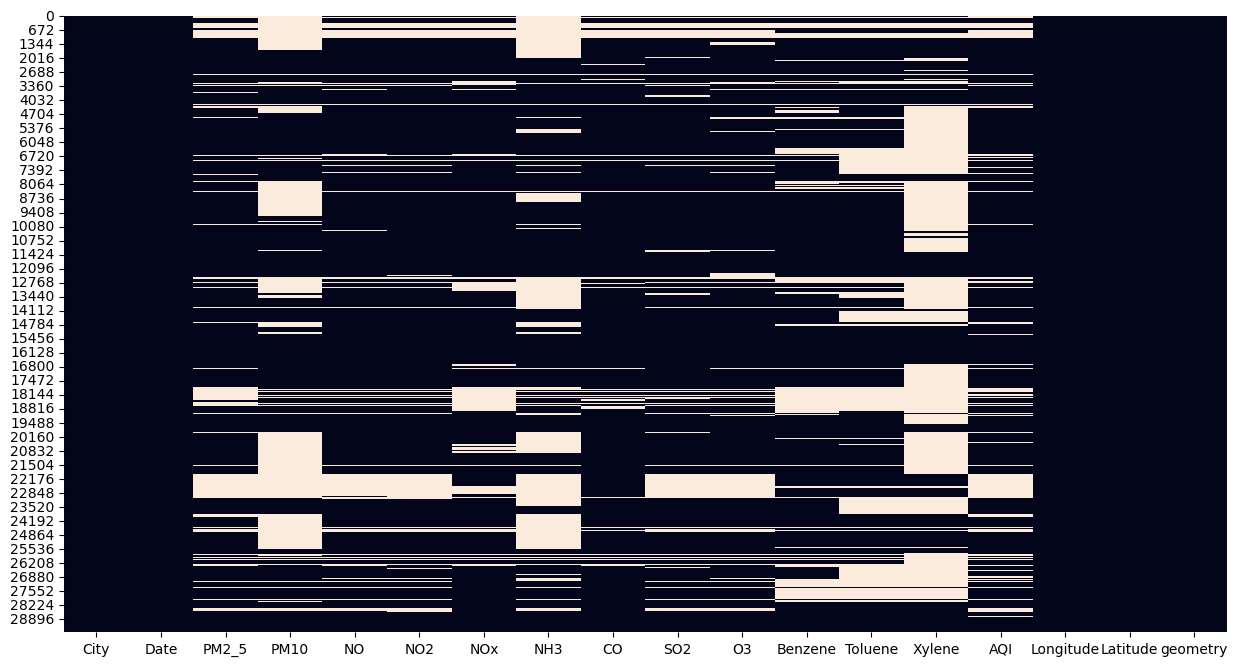

In [11]:
# Check the missing values with heatmap :

sns.heatmap(AQI_city_day.isnull(), cbar=False)
plt.show()


In [12]:
# Try methods to impute missing values :

AQI_city_day.groupby(['City','Date'])['AQI'].mean()


City           Date      
Ahmedabad      2015-01-01     NaN
               2015-01-02     NaN
               2015-01-03     NaN
               2015-01-04     NaN
               2015-01-05     NaN
                             ... 
Visakhapatnam  2020-06-27    41.0
               2020-06-28    70.0
               2020-06-29    68.0
               2020-06-30    54.0
               2020-07-01    50.0
Name: AQI, Length: 29531, dtype: float64

In [13]:
# Converting Datetime variable into datetime data type :

AQI_city_day['Date'] = AQI_city_day['Date'].apply(pd.to_datetime)

In [14]:
# Check whether it is converted or not :

AQI_city_day.dtypes

City                 object
Date         datetime64[ns]
PM2_5               float64
PM10                float64
NO                  float64
NO2                 float64
NOx                 float64
NH3                 float64
CO                  float64
SO2                 float64
O3                  float64
Benzene             float64
Toluene             float64
Xylene              float64
AQI                 float64
Longitude           float64
Latitude            float64
geometry           geometry
dtype: object

* Datetime variable is changed into datetime datatype.

In [15]:
# Impute the missing values by grouping city with and average of 5 days:

data_fill = AQI_city_day.iloc[:, :15].fillna(AQI_city_day.iloc[:, :15].groupby(['City', pd.Grouper(key='Date', freq='5D')]).transform('mean'))

In [16]:
# After inputing missing values by day checking for the missing values :

values = data_fill.isnull().sum()
percentage = 100*data_fill.isnull().sum()/len(data_fill)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('Purples')

,No of missing values,Percent of missing values
Xylene,17618,59.660000
PM10,10495,35.540000
NH3,9742,32.990000
Toluene,7396,25.040000
Benzene,4888,16.550000
PM2_5,3990,13.510000
NOx,3700,12.530000
AQI,3661,12.400000
O3,3201,10.840000
SO2,3050,10.330000


* Still the missing values are present in the data, let's try to fill with average of month.

In [17]:
# Impute the missing values by grouping city and month :

data_fill = data_fill.fillna(data_fill.groupby(['City', pd.Grouper(key='Date', freq='M')]).transform('mean'))

In [18]:
# After inputing missing values by month check for the missing values :

values = data_fill.isnull().sum()
percentage = 100*data_fill.isnull().sum()/len(data_fill)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('Blues')

,No of missing values,Percent of missing values
Xylene,17033,57.680000
PM10,9570,32.410000
NH3,8900,30.140000
Toluene,6742,22.830000
Benzene,3999,13.540000
PM2_5,3067,10.390000
NOx,3001,10.160000
AQI,2596,8.790000
O3,2113,7.160000
NO2,2056,6.960000


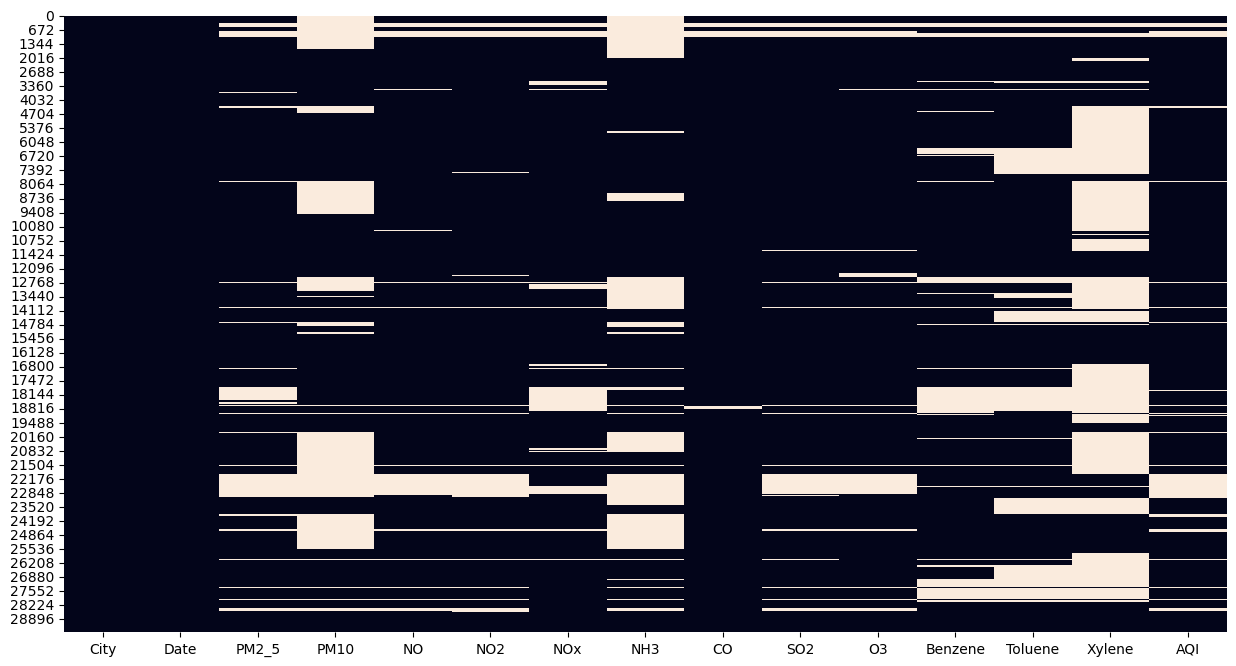

In [19]:
sns.heatmap(data_fill.isnull(), cbar=False)
plt.show()

In [20]:
# Imputing missing values by beckward fill :

data_fill = data_fill.fillna(method = 'bfill',axis=0)

In [21]:
# Still data is missing in the columns, hence using forward fill to impute this :

data_fill = data_fill.fillna(method = 'ffill',axis=0)

In [22]:
# After inputing missing values by bfill abd ffill:

values = data_fill.isnull().sum()
percentage = 100*data_fill.isnull().sum()/len(data_fill)
table = pd.concat([values,percentage.round(2)],axis=1)
table.columns = ['No of missing values','Percent of missing values']
table[table['No of missing values']!=0].sort_values('Percent of missing values',ascending=False).style.background_gradient('Blues')

,No of missing values,Percent of missing values


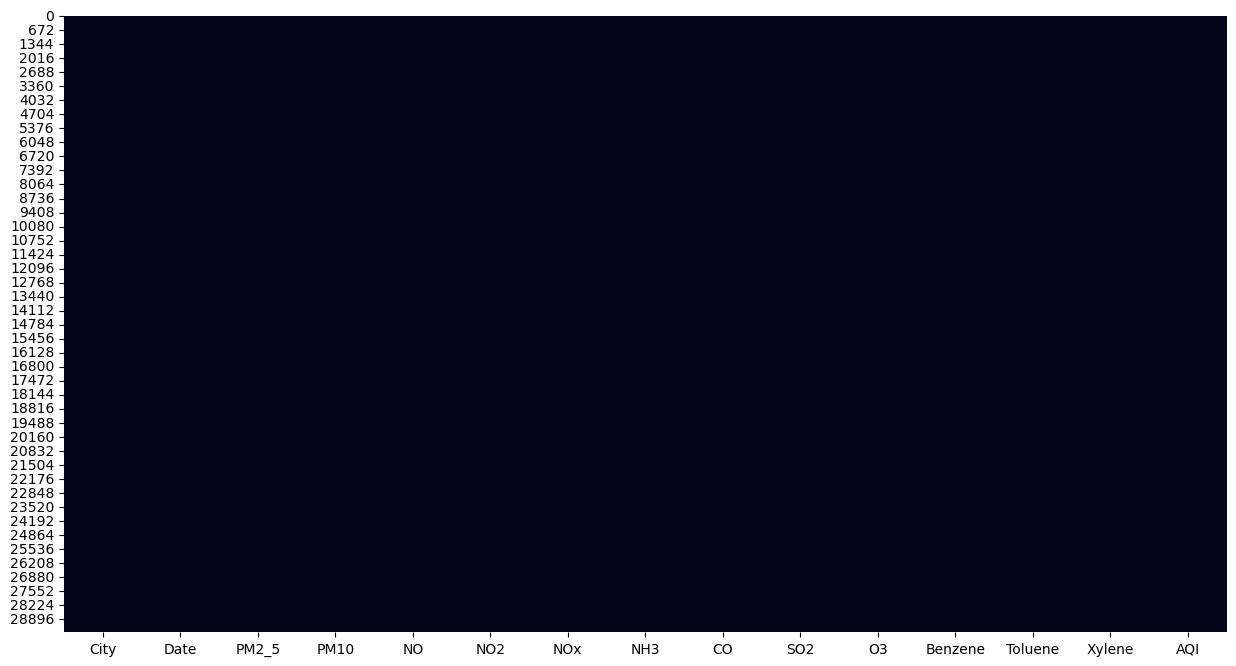

In [23]:
sns.heatmap(data_fill.isnull(), cbar=False)
plt.show()

In [24]:
print(data_fill.columns)

Index(['City', 'Date', 'PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI'],
      dtype='object')


In [25]:
data_fill.head()

,City,Date,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
0,Ahmedabad,2015-01-01,81.367222,137.342727,0.92,18.22,17.15,26.64,0.92,27.64,133.36,0.00,0.02,0.00,309.416667
1,Ahmedabad,2015-01-02,81.367222,137.342727,0.97,15.69,16.46,26.64,0.97,24.55,34.06,3.68,5.50,3.77,309.416667
2,Ahmedabad,2015-01-03,81.367222,137.342727,17.40,19.30,29.70,26.64,17.40,29.07,30.70,6.80,16.40,2.25,309.416667
3,Ahmedabad,2015-01-04,81.367222,137.342727,1.70,18.48,17.97,26.64,1.70,18.59,36.08,4.43,10.14,1.00,309.416667
4,Ahmedabad,2015-01-05,81.367222,137.342727,22.10,21.42,37.76,26.64,22.10,39.33,39.31,7.01,18.89,2.78,309.416667


In [26]:
# After imputing missing values, check summary statistics of the data :

data_fill.describe()

,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000
mean,67.612826,101.114376,21.370930,27.232570,35.339042,21.864417,3.327671,18.484640,33.310576,3.231101,7.329071,3.533626,168.214891
std,64.021390,84.360941,28.809299,24.026101,33.420449,23.376915,11.952032,24.826381,21.306223,15.899821,18.504928,6.032020,139.923308
min,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000
25%,26.992500,44.560000,5.900000,10.610000,13.885000,6.756200,0.500000,5.770000,17.430000,0.010000,0.090000,0.000000,79.901235
50%,47.900000,72.040000,10.620000,20.620000,24.590000,15.340000,0.900000,9.550000,29.410000,0.760000,1.860000,0.890000,117.000000
75%,84.650000,137.342727,23.255000,36.420000,44.087111,29.430000,1.510000,17.570000,43.745000,2.860000,7.140000,4.150000,218.636364
max,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000


*  After imputing missing values by this method, mean and the standard deviation is not much changed.

In [27]:
data=data_fill.copy()

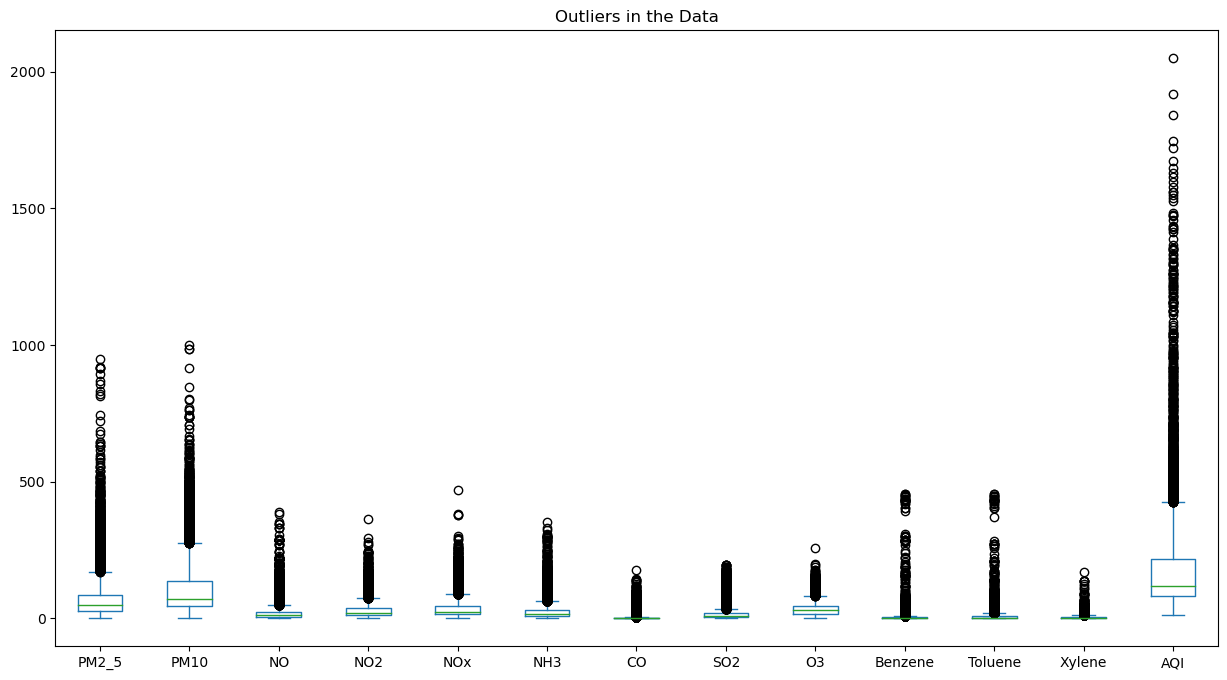

<Figure size 1500x800 with 0 Axes>

In [28]:
# Checking for outliers :

data_fill.plot(kind='box')
plt.title("Outliers in the Data")
plt.show()
plt.savefig('Outliers.png', dpi=300, bbox_inches='tight')

In [29]:
from scipy import stats

# Assuming your DataFrame is called "df"
# Calculate the z-scores for each column
z_scores = stats.zscore(data[['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2','O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']])

# Set a threshold z-score above which a data point is considered an outlier
threshold =3

# Remove outliers by filtering out all rows with a z-score greater than the threshold
data[['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2','O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']] = data[['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2','O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']][(z_scores < threshold)]


In [30]:
data.isnull().sum()

City          0
Date          0
PM2_5       614
PM10        685
NO          428
NO2         524
NOx         467
NH3         459
CO          548
SO2        1441
O3          399
Benzene     158
Toluene     319
Xylene      263
AQI         340
dtype: int64

In [31]:
data.dropna(inplace=True)

In [32]:
data.isnull().sum()

City       0
Date       0
PM2_5      0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
Xylene     0
AQI        0
dtype: int64

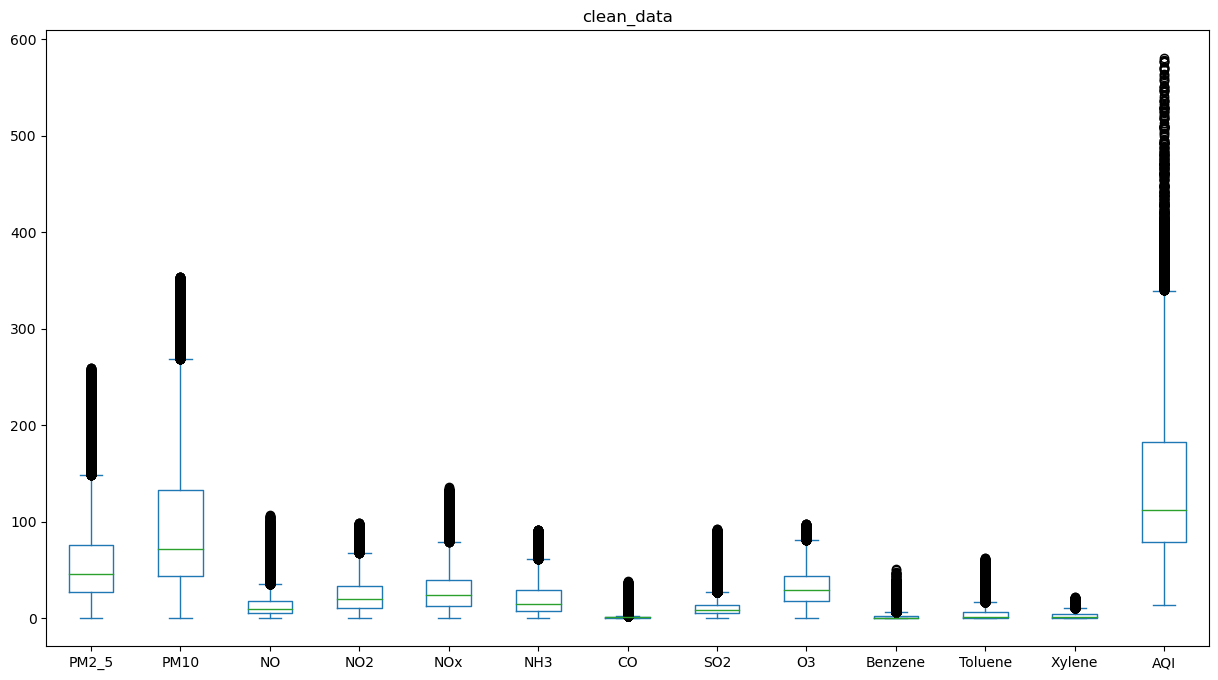

<Figure size 1500x800 with 0 Axes>

In [33]:
data.plot(kind='box')
plt.title("clean_data")
plt.show()
plt.savefig('Outliers.png', dpi=300, bbox_inches='tight')

### Interpretation

* From the box plot, can say that the outliers are present in the data, but this is the time series data.
* So we can not remove all outliers, if we do this the continuity will not remain for the data.

## Univariate ad Multivariate Month wise Analysis

In [34]:
# In this we are not concidering the AQI_Bucket column, because it is not nessasary for our analysis.
# Here, we do analysis on all over country, so Aggregating the data into month wise and creating the new dataframe.

AQI_df = data.groupby(['City', (data.Date.dt.strftime('%Y-%m'))]).mean()

# Reset index :
AQI_df = AQI_df.reset_index()

# Check the First 5 observation :
AQI_df.head()

,City,Date,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
0,Ahmedabad,2015-01,80.740899,137.342727,8.891429,23.060000,28.761429,26.64,8.891429,41.894286,44.722381,1.310952,2.582381,2.697143,299.674603
1,Ahmedabad,2015-02,83.155000,137.342727,8.047105,24.147368,30.995526,26.64,8.047105,54.017368,45.193421,5.124737,12.177105,2.764474,344.105263
2,Ahmedabad,2015-03,92.188333,137.342727,8.362262,24.424881,32.181905,26.64,8.362262,49.999762,46.020833,7.227976,15.386190,2.254167,299.690476
3,Ahmedabad,2015-04,98.601923,137.342727,6.158846,19.450769,24.903462,26.64,6.158846,47.905769,29.548462,2.639231,8.057692,3.266923,275.647436
4,Ahmedabad,2015-05,71.246552,137.342727,7.844828,16.702759,23.523448,26.64,7.844828,34.636552,31.352414,3.230000,8.565517,4.822414,249.224138


In [35]:
AQI_df.describe()

,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000
mean,61.954768,95.400427,15.508434,25.523973,31.852424,20.595817,1.767571,13.441784,32.759297,2.229477,6.107239,3.320583,151.474706
std,42.660749,63.206121,13.600133,16.940917,25.032708,15.863441,3.346783,12.965765,16.589221,3.317427,8.789564,4.372901,90.179108
min,2.000000,3.555287,0.022500,0.070000,0.000000,0.017500,0.000000,1.229000,0.052500,0.000000,0.000000,0.000000,17.000000
25%,31.766429,47.514000,6.798333,11.837667,14.640948,7.883548,0.576667,6.144839,20.475000,0.123846,0.330000,0.000000,88.032258
50%,49.706957,79.441552,10.981429,22.331613,25.267500,16.240000,0.943704,9.331548,31.136000,1.111034,2.602000,1.190000,120.000000
75%,80.816667,137.342727,20.009000,34.977931,40.547619,30.046452,1.487200,14.420000,43.152667,3.049167,7.768244,4.150000,197.137931
max,221.335714,327.186000,90.910000,89.765000,121.174000,86.210000,30.282800,90.600000,88.508750,27.964783,51.335789,17.916667,535.777778


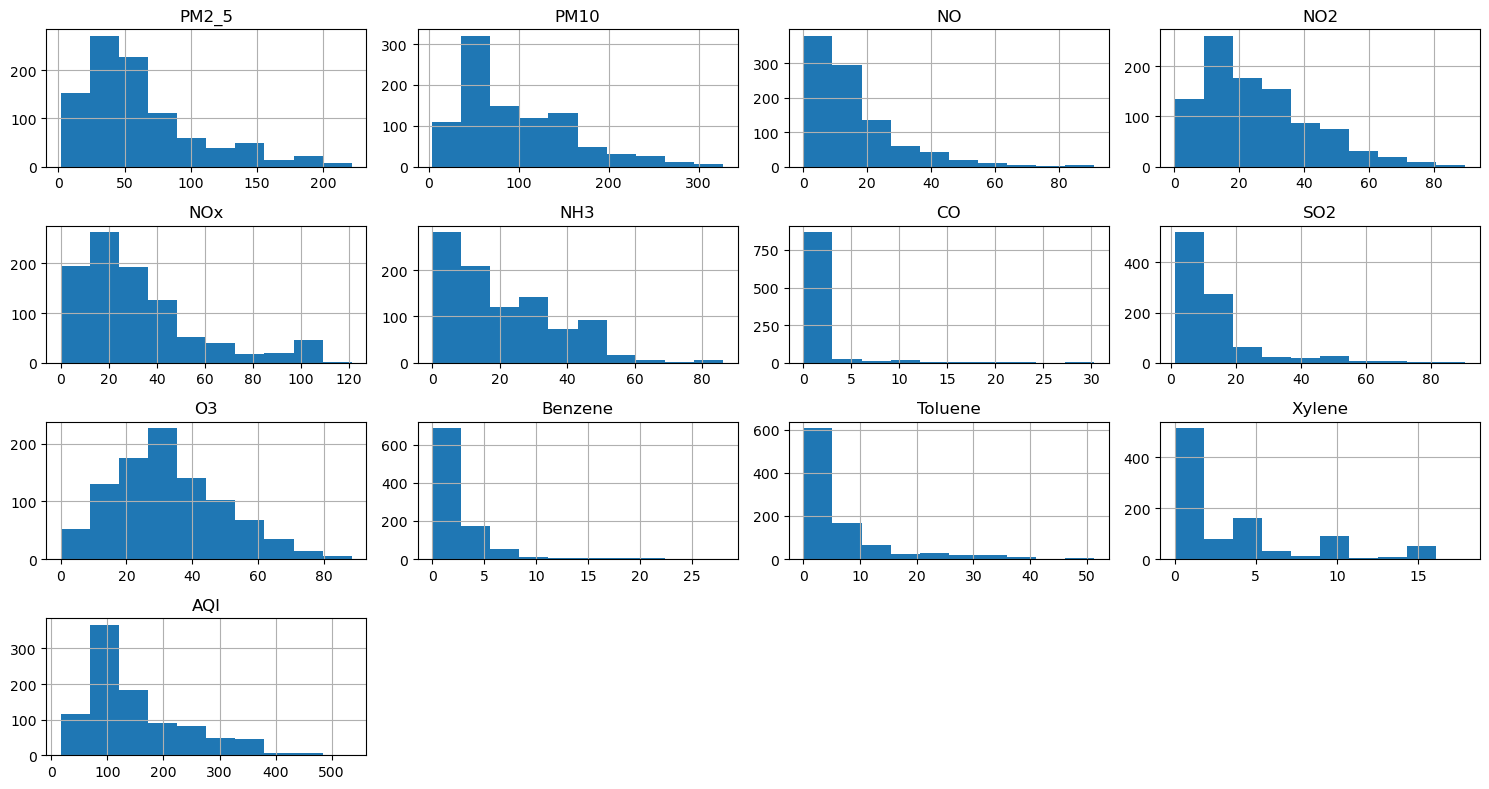

Skewness :
 PM2_5      1.310032
PM10       1.010859
NO         1.976403
NO2        0.912806
NOx        1.320127
NH3        0.892725
CO         4.841186
SO2        2.626591
O3         0.511202
Benzene    3.463085
Toluene    2.159469
Xylene     1.465082
AQI        1.212010
dtype: float64


<Figure size 1500x800 with 0 Axes>

In [36]:
# Check the distribution of the all numerical columns and print skewness of the data :

AQI_df.drop(['City', 'Date'], axis=1).hist()
plt.tight_layout()
plt.title("Distribution of Data")
plt.show()
plt.savefig('Distribution of data.png')
# Print the skewness of the data :
print('Skewness :\n', AQI_df.drop(['City', 'Date'], axis=1).skew())

### Interpretation:

* From the plot and skewness, can say that the Benzene, Toluene, CO, NO2 are highely skewed and right skewed.

The impact of  PM2_5 on AQI


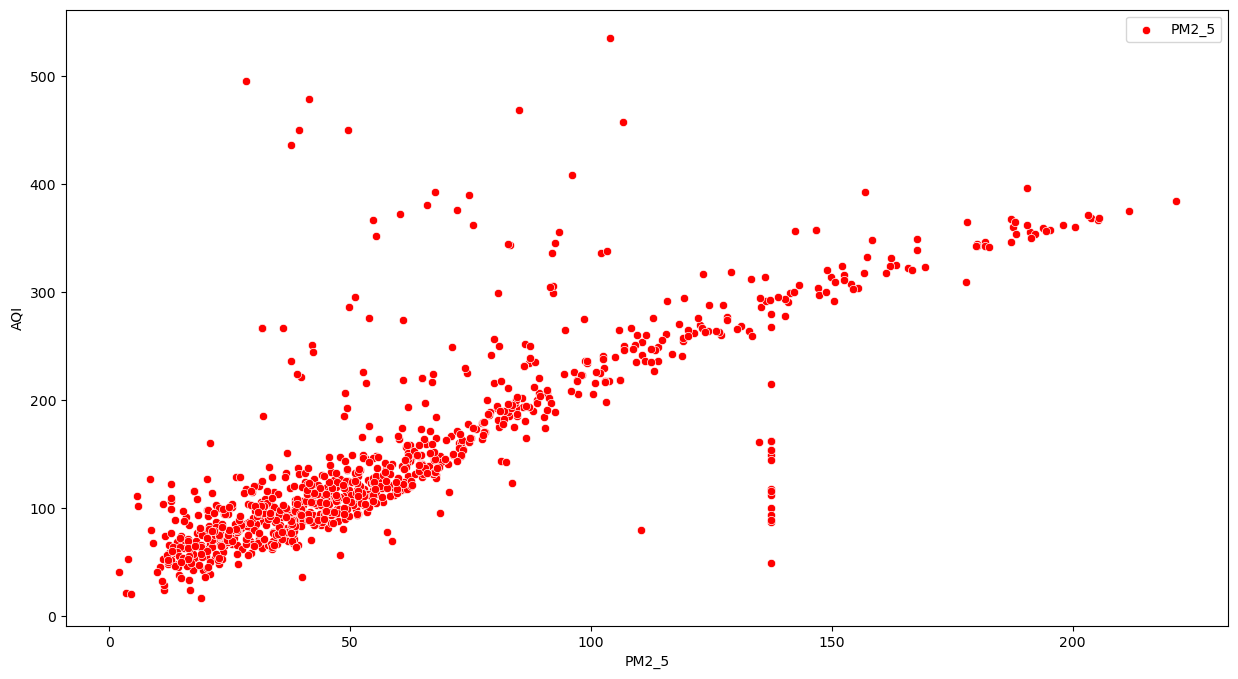

The impact of  PM10 on AQI


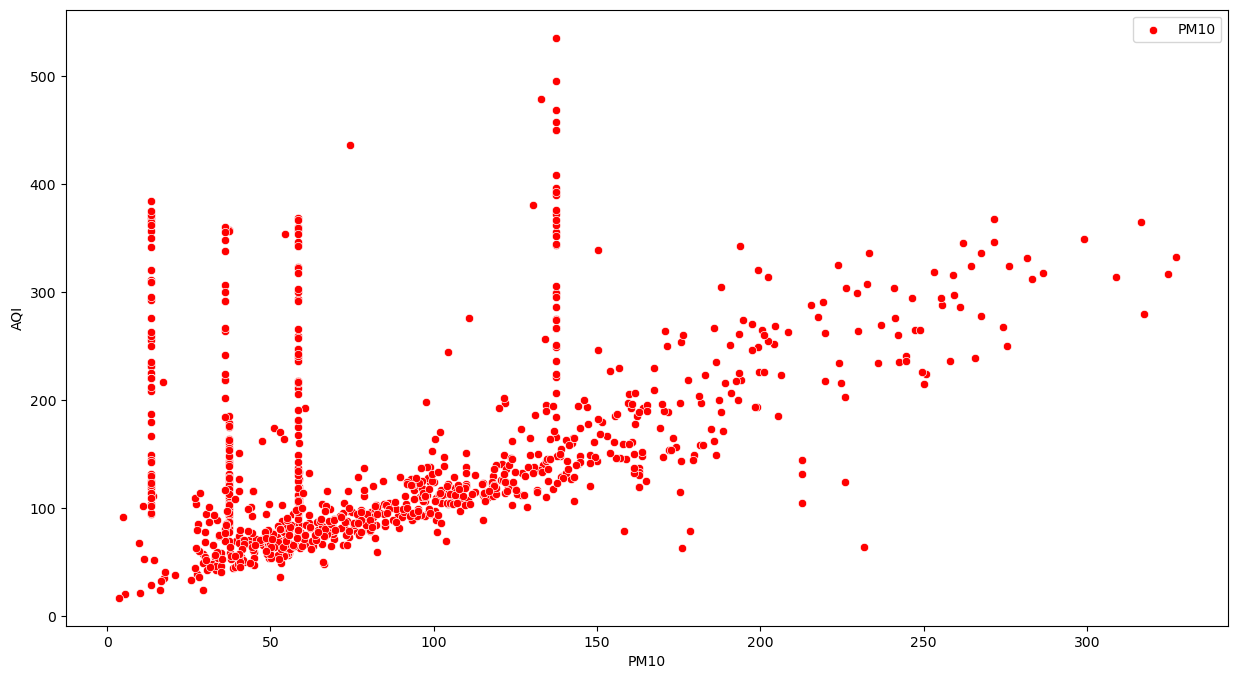

The impact of  NO on AQI


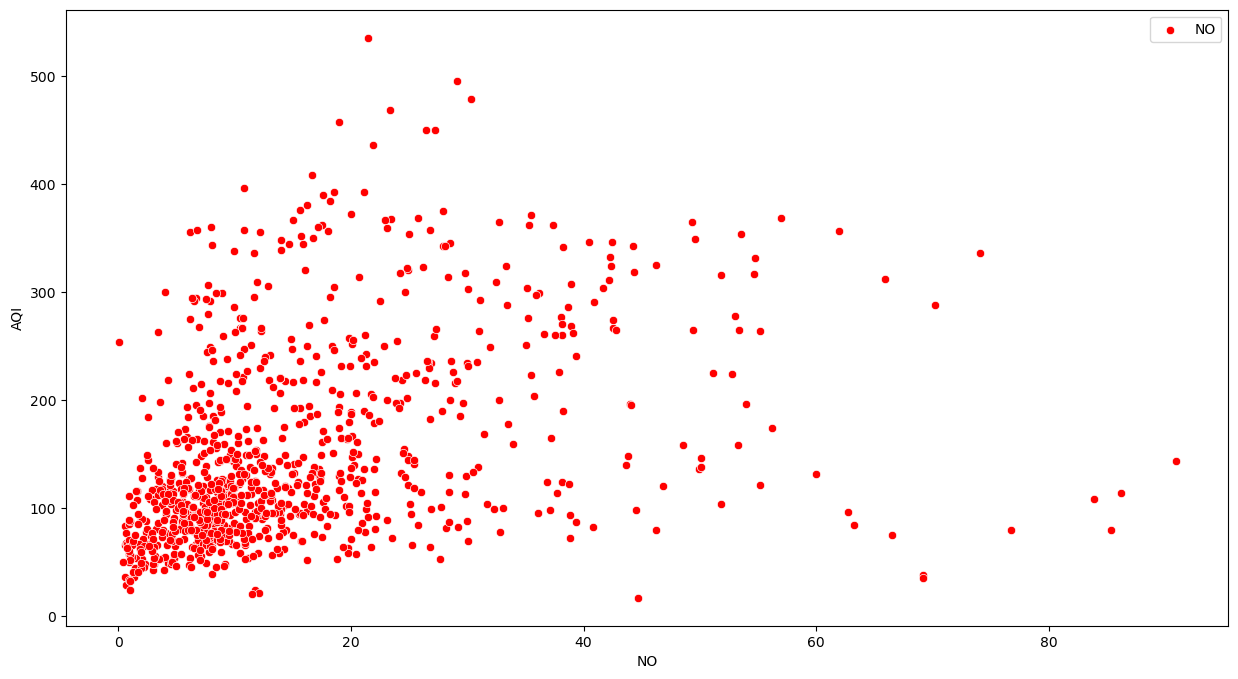

The impact of  NO2 on AQI


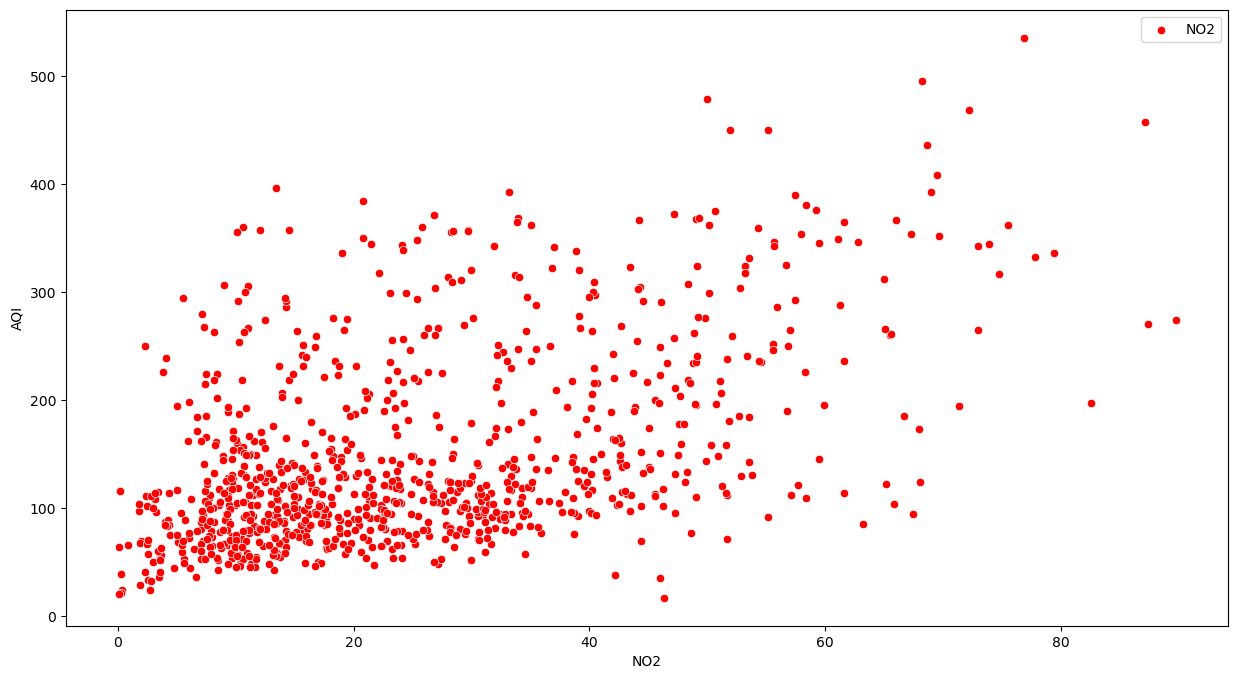

The impact of  NOx on AQI


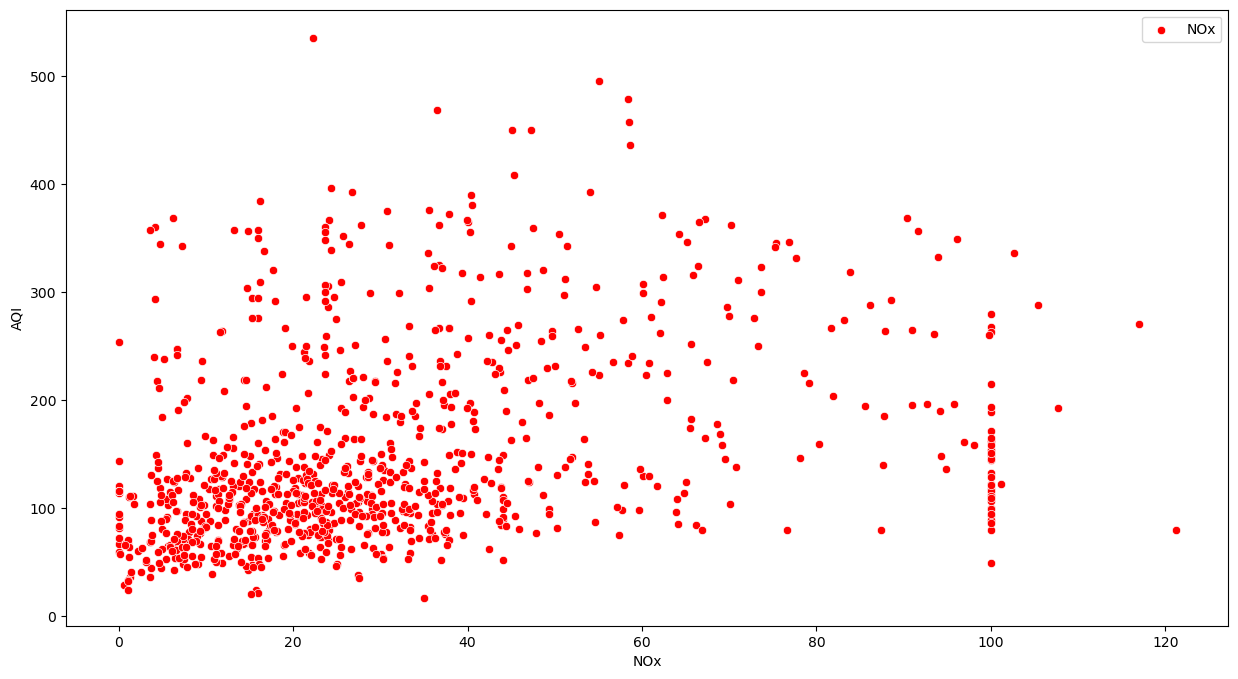

The impact of  NH3 on AQI


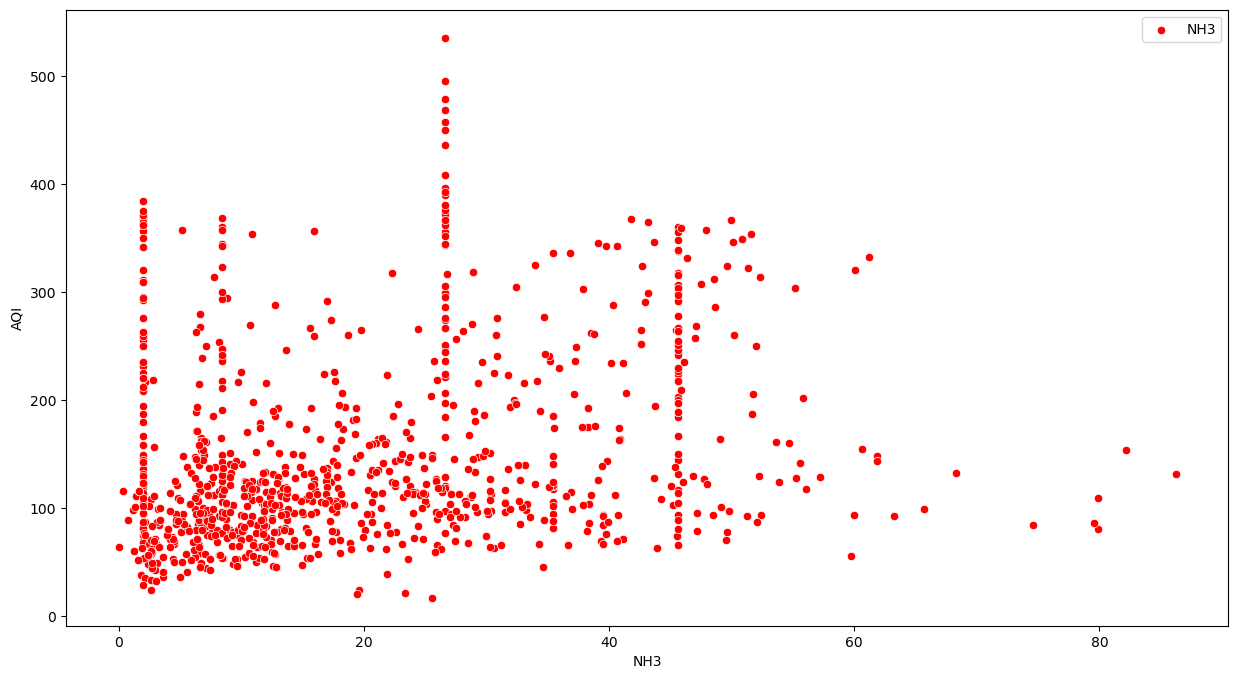

The impact of  CO on AQI


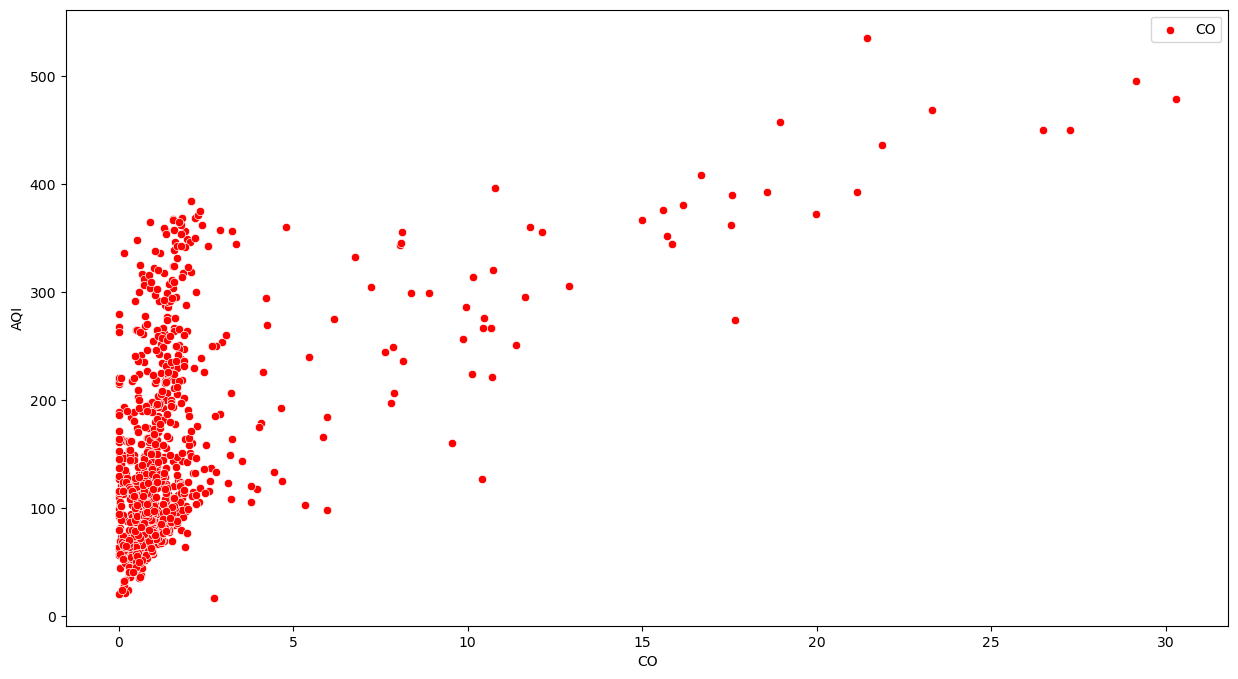

The impact of  SO2 on AQI


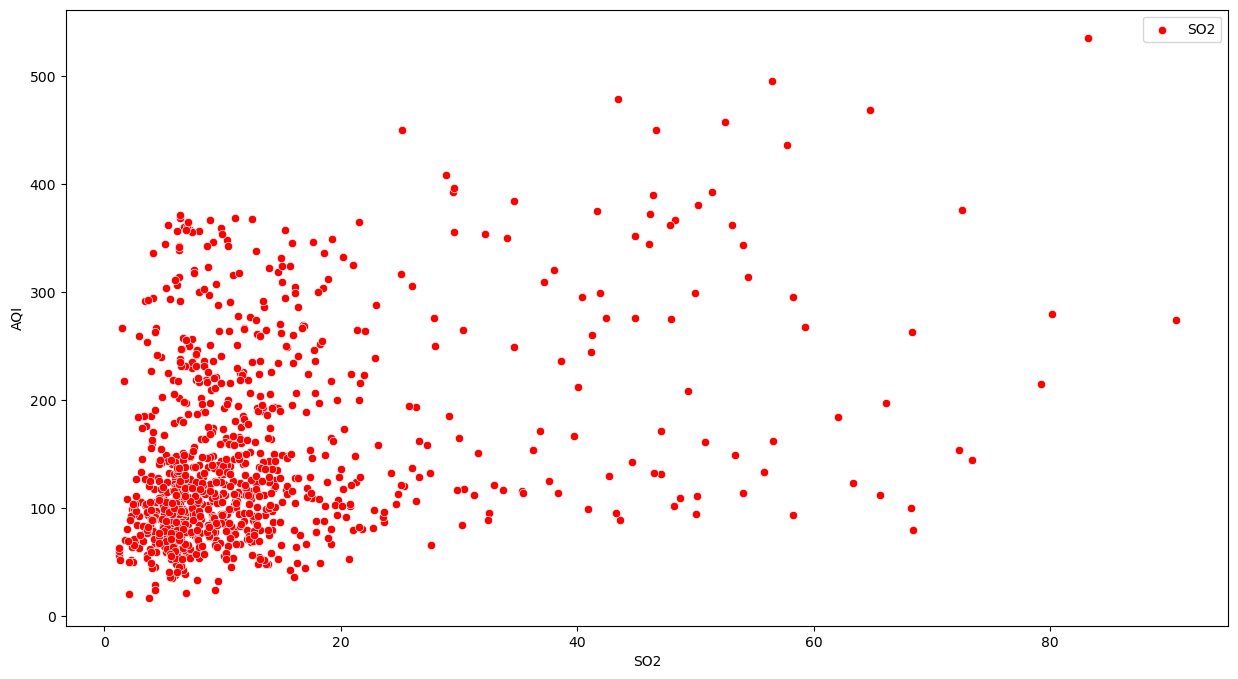

The impact of  O3 on AQI


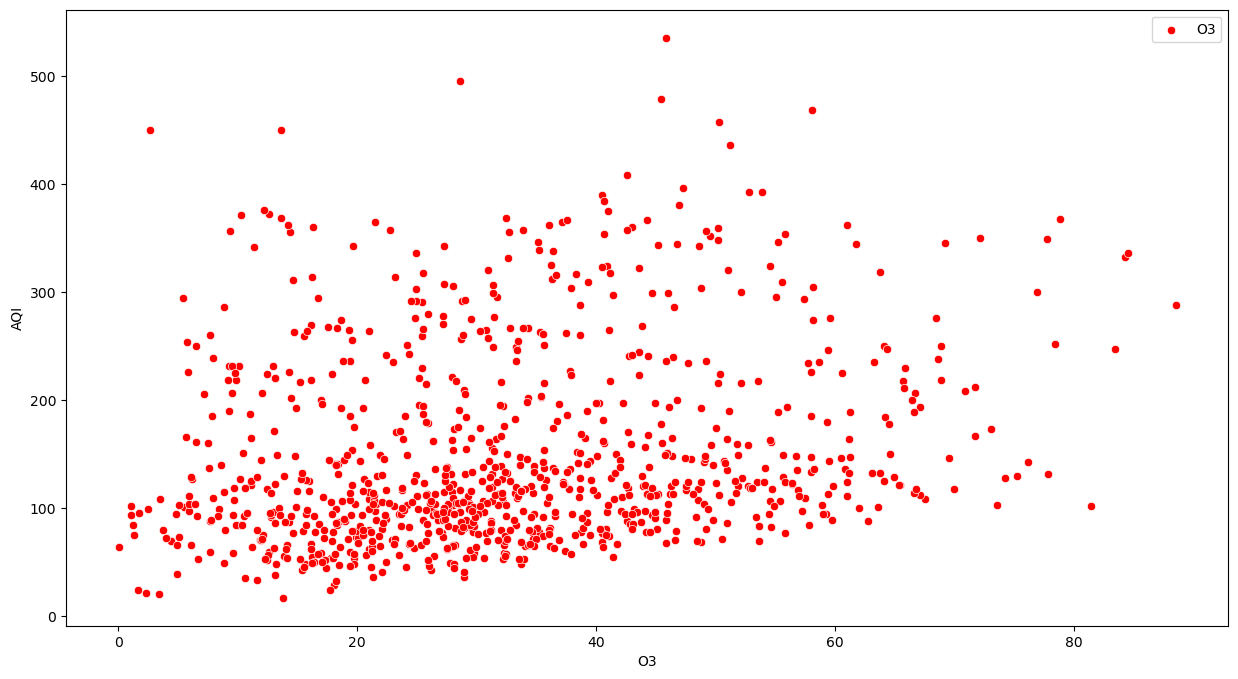

The impact of  Benzene on AQI


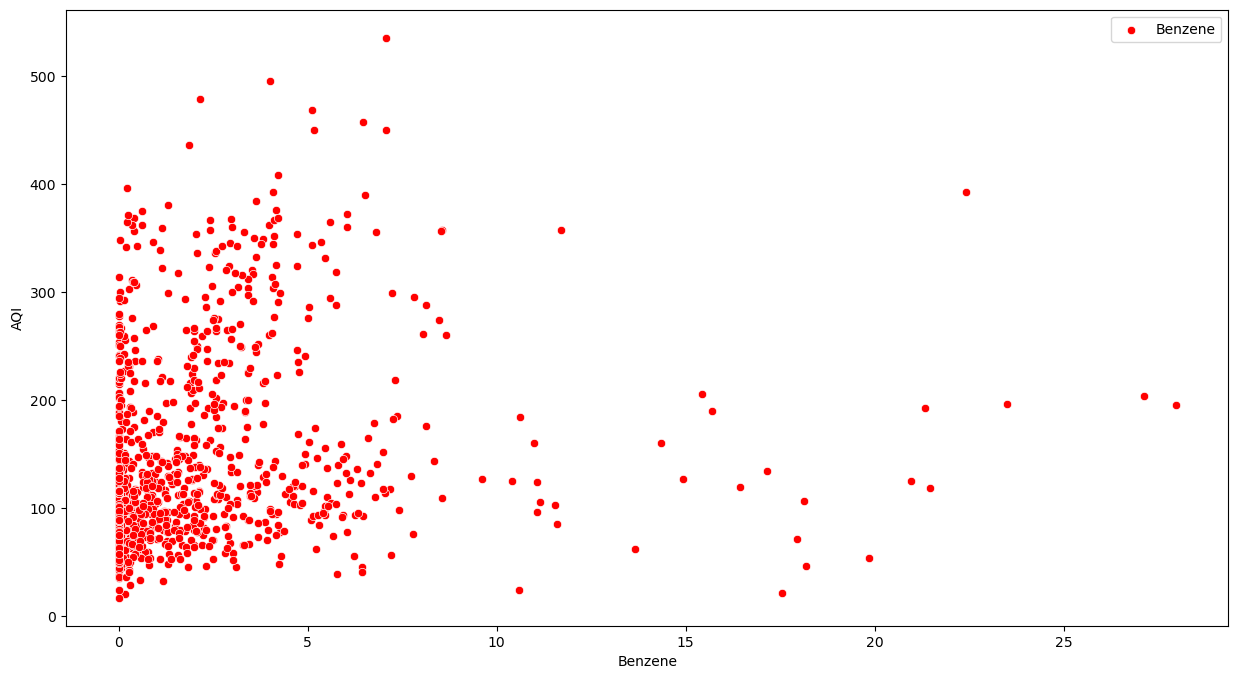

The impact of  Toluene on AQI


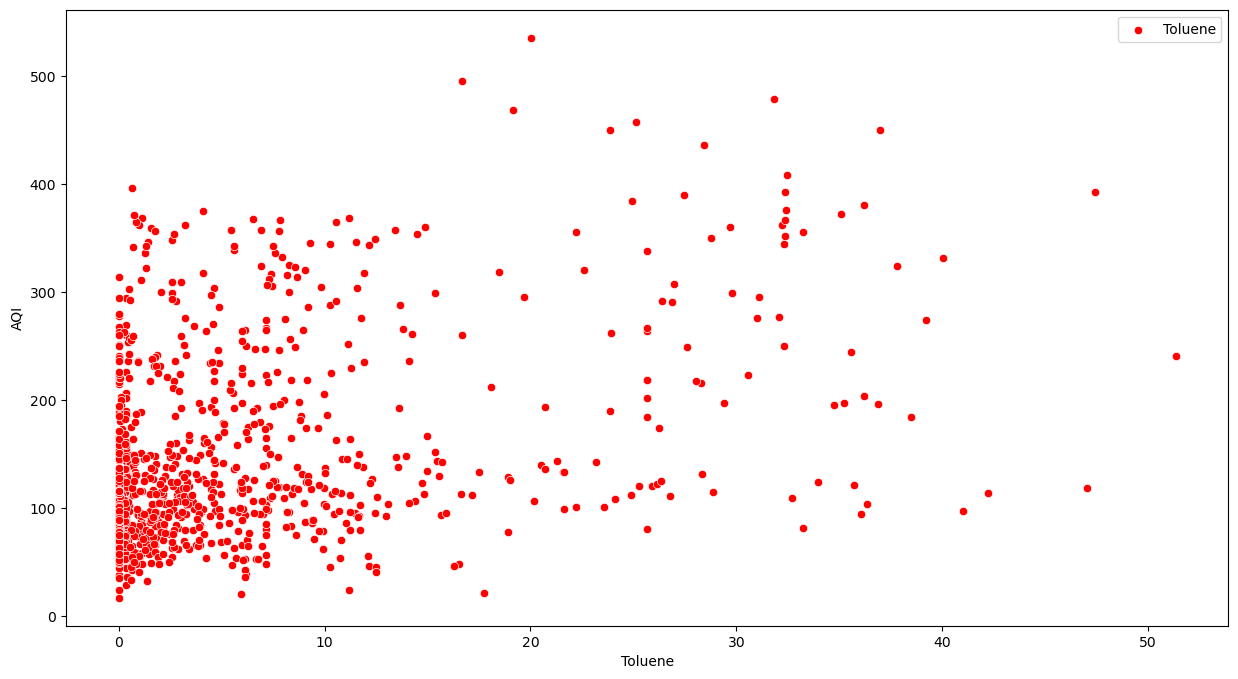

In [37]:
# Check the effect of all pollutants on AQI :

for i in AQI_df.iloc[:, 2:13]:
    print('The impact of ', i, 'on AQI')
    sns.scatterplot(x = i, y ='AQI', data = AQI_df,marker="o",sizes=200,color="r",label=i)
    plt.legend()
    plt.show()


### Interpretations:

* From the scatterplot, can say that the PM2.5, PM10, CO has positive correlation with AQI.
* It means, when pollutants increse, the AQI increases.
* We will find the relationship of other variables usign heatmap

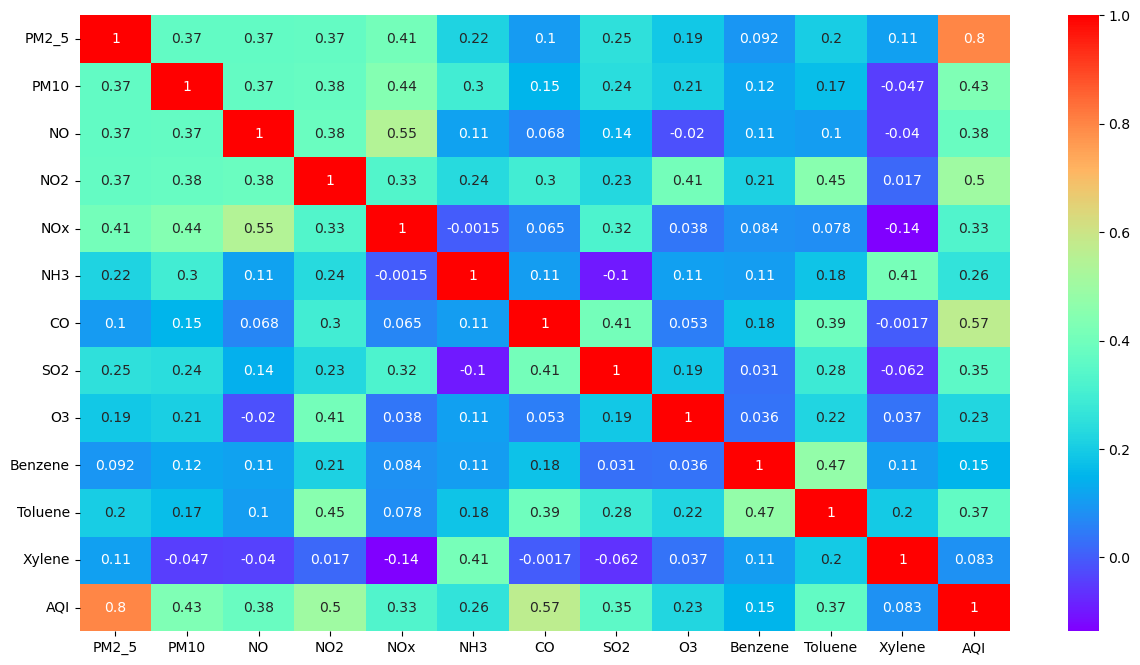

In [38]:
# Correlation of the numerical data with heatmap :

sns.heatmap(AQI_df.corr(), annot=True, cmap='rainbow')
plt.show()

### Interpretations:

* From the heatmap, we can say that other pollutants doest not affect the AQI much.
* They have the positive correlation with AQI but not strong correlation.
* PM2.5 and PM10 has good positive correlation between them.
* Also Toluene and Benzene have high correlation.

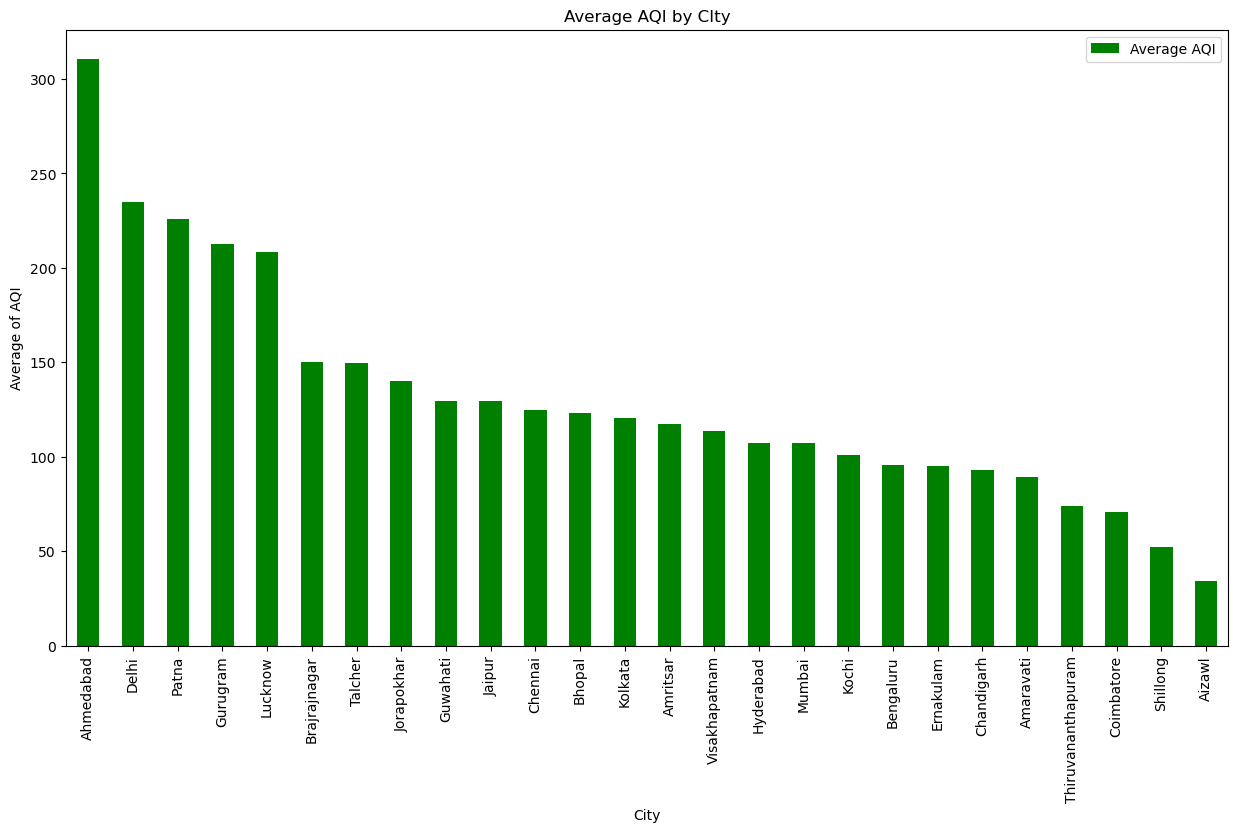

In [39]:
# Check the citywise average of AQI :

AQI_df.groupby('City')['AQI'].mean().sort_values(ascending=False).plot(kind='bar',color="g",label="Average AQI")
plt.ylabel('Average of AQI')
plt.title("Average AQI by CIty")
plt.legend()
plt.show()

In [57]:
dh=pd.read_csv("C:\\Users\\snaga\\OneDrive\\Desktop\\state.csv")

,Unnamed: 0,ST_NAME,AQI_DATA
0,0,ANDAMAN AND NICOBAR ISLANDS,NaN
1,1,Andhra Pradesh,89.511415
2,2,Arunachal Pradesh,NaN
3,3,Assam,129.688454
4,4,Bihar,226.050314


<AxesSubplot:>

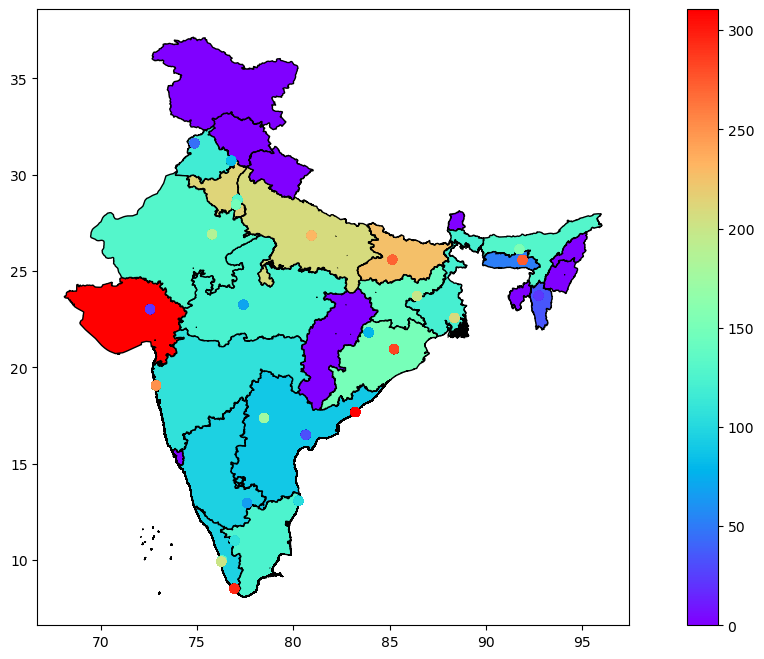

In [58]:
#importing India shape file as df
df=gpd.read_file("C:\\Users\\snaga\\OneDrive\\Desktop\\in\\INDIA_states.shp")
df["AQI_VAL"]=dh["AQI_DATA"]

base=df.plot(column="AQI_VAL",cmap="rainbow",edgecolor='black',legend=True,)
geo.plot(ax=base,cmap="rainbow",)


### Interpretations:

* From the plot, we can say that Ahmedabad city has very high average of AQI through out 5 years, then Delhi, Patna, Gurugram.
* Aizawl has very less average of AQI, maybe the reason is mountainous area.

## Statistical Tests

* To start working with mdel building, let's perform statistical test.
* Here, we have only numerical columns, so we performed the Anova test, and checked which pollutants are affecting more on AQI.
* We are using ordinary least square method to check the effect of pollutants on AQI.
* ANOVA is helpful for testing three or more variables.

In [39]:
# First seperate target and independent variables :
x = AQI_df.drop(['City', 'Date', 'AQI'], axis=1)
#x = sm.add_constant(x)
y= AQI_df.AQI

# Fitting the model
model = OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    AQI   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              2733.
Date:                Thu, 23 Feb 2023   Prob (F-statistic):                        0.00
Time:                        16:14:47   Log-Likelihood:                         -4554.4
No. Observations:                 949   AIC:                                      9133.
Df Residuals:                     937   BIC:                                      9191.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PM2_5          1.4955      0.027     55.651      0.000       1.443       1.548
PM10           0.1304      0.019      6.861      0.000       0.093       0.168
NO             0.7029      0.090      7.819      0.000       0.527       0.879
NO2            0.2631      0.079      3.335      0.001       0.108       0.418
NOx           -0.2420      0.051     -4.702      0.000      -0.343      -0.141
NH3            0.0794      0.073      1.094      0.274      -0.063       0.222
CO            13.0731      0.343     38.117      0.000      12.400      13.746
SO2           -0.2595      0.091     -2.859      0.004      -0.438      -0.081
O3             0.4186      0.057      7.291      0.000       0.306       0.531
Benzene       -0.4713      0.330     -1.429      0.153      -1.119       0.176
Toluene       -0.0012      0.146     -0.008      0.993      -0.288       0.286
Xylene         0.2218      0.250      0.887      0.375      -0.269       0.712
==============================================================================
Omnibus:                      112.188   Durbin-Watson:                   0.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              935.496
Skew:                          -0.133   Prob(JB):                    7.24e-204
Kurtosis:                       7.857   Cond. No.                         52.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Print significant variables which are most affect on AQI :

significant = model.pvalues[model.pvalues < 0.05].sort_values(ascending=True)

print('Significant vaeiables which more affect on AQI :\n', significant)

Significant vaeiables which more affect on AQI :
 PM2_5    2.774664e-299
CO       1.034701e-192
NO        1.434162e-14
O3        6.541010e-13
PM10      1.238154e-11
NOx       2.966255e-06
NO2       8.860833e-04
SO2       4.341676e-03
dtype: float64


### Interpretations:

* The pollutants CO, PM2.5, NO2 and SO2 are affecting the most on AQI
* Benzene and NO are least significant.

# Multi Linear Regression Model

In [41]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=3,test_size=0.2)
model=LinearRegression()
model.fit(x_train,y_train)

y_pred=model.predict(x_test)



In [42]:

print("coef of determination(accuracy of Model):",model.score(x_train,y_train)*100,"percent")
print("*******************************************************")
print("intercept is:",model.intercept_)
print("*******************************************************")
mae1 = mean_absolute_error(y_test, y_pred)
print("mean absolute error",mae1)




coef of determination(accuracy of Model): 90.06172778136546 percent
*******************************************************
intercept is: 17.25179018772488
*******************************************************
mean absolute error 20.09092741263187


# Visualization

Text(0, 0.5, 'Predicted value of AQI')

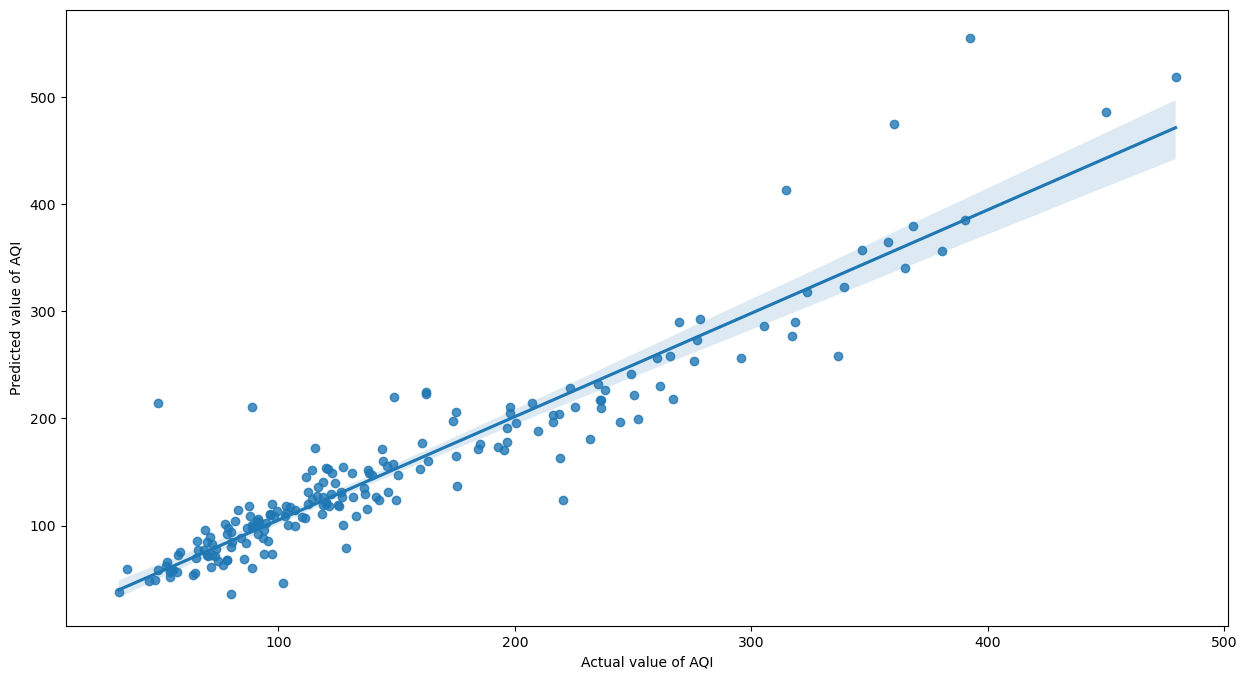

In [43]:
import matplotlib.pyplot as plt
sns.regplot(y_test,y_pred)
plt.xlabel('Actual value of AQI')
plt.ylabel('Predicted value of AQI')


# Random forest Regresssion

In [44]:
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(x_train, y_train)
y_pred1 = model.predict(x_test)

r2 = r2_score(y_test, y_pred1)


print("Accuracy is:: ", r2*100,"percent")

print("*******************************************************")
mae2 = mean_absolute_error(y_test, y_pred1)
print("mean absolute error",mae2)

Accuracy is::  93.57444362392091 percent
*******************************************************
mean absolute error 15.459628917216765


# Visualization

Text(0, 0.5, 'Predicted value of AQI')

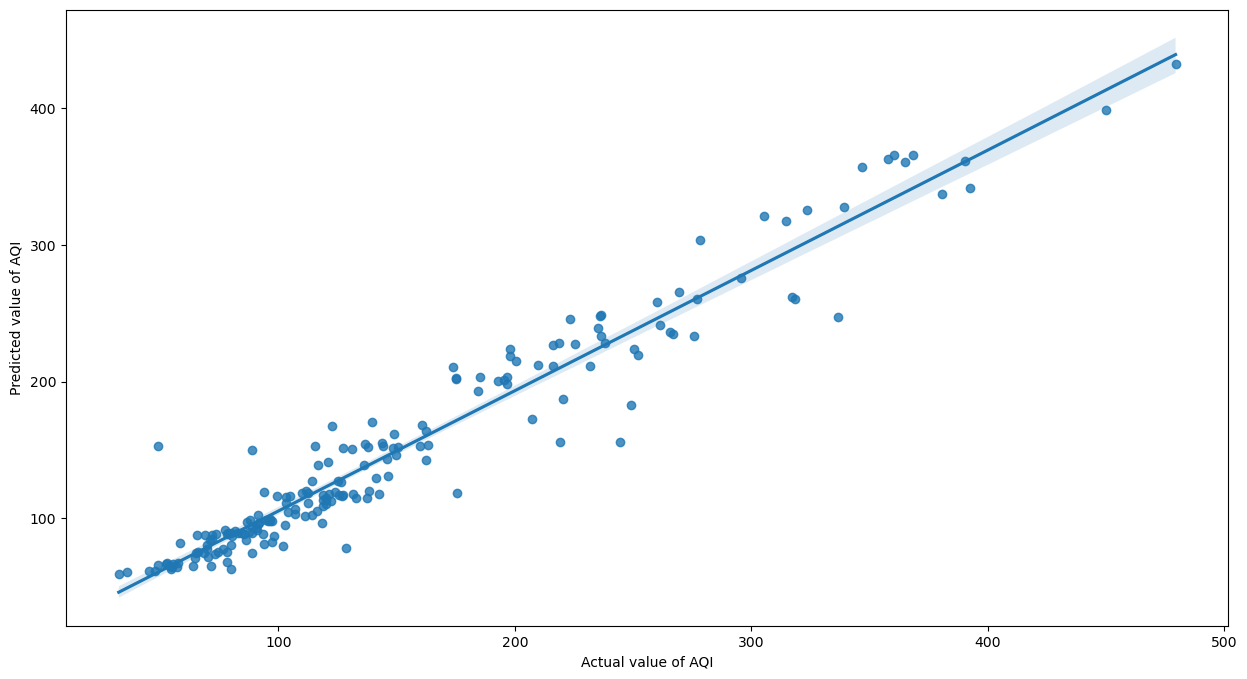

In [45]:
sns.regplot(y_test,y_pred1)
plt.xlabel('Actual value of AQI')
plt.ylabel('Predicted value of AQI')


# Decision Tree Regressor

In [46]:
# Create a decision tree regressor object
regressor = DecisionTreeRegressor(max_depth=3,random_state=20)

# Fit the regressor with the training data
regressor.fit(x_train, y_train)

# Make predictions on the testing data
y_pred2 = regressor.predict(x_test)
r4 = r2_score(y_test, y_pred2)
print("Accuracy is:",r4*100,"percent")
print("*************************************")

mae3 = mean_absolute_error(y_test, y_pred2)
print("mean absolute error",mae3)

Accuracy is: 82.24528017778303 percent
*************************************
mean absolute error 26.20649765527541


# Visualization

Text(0, 0.5, 'Predicted value of AQI')

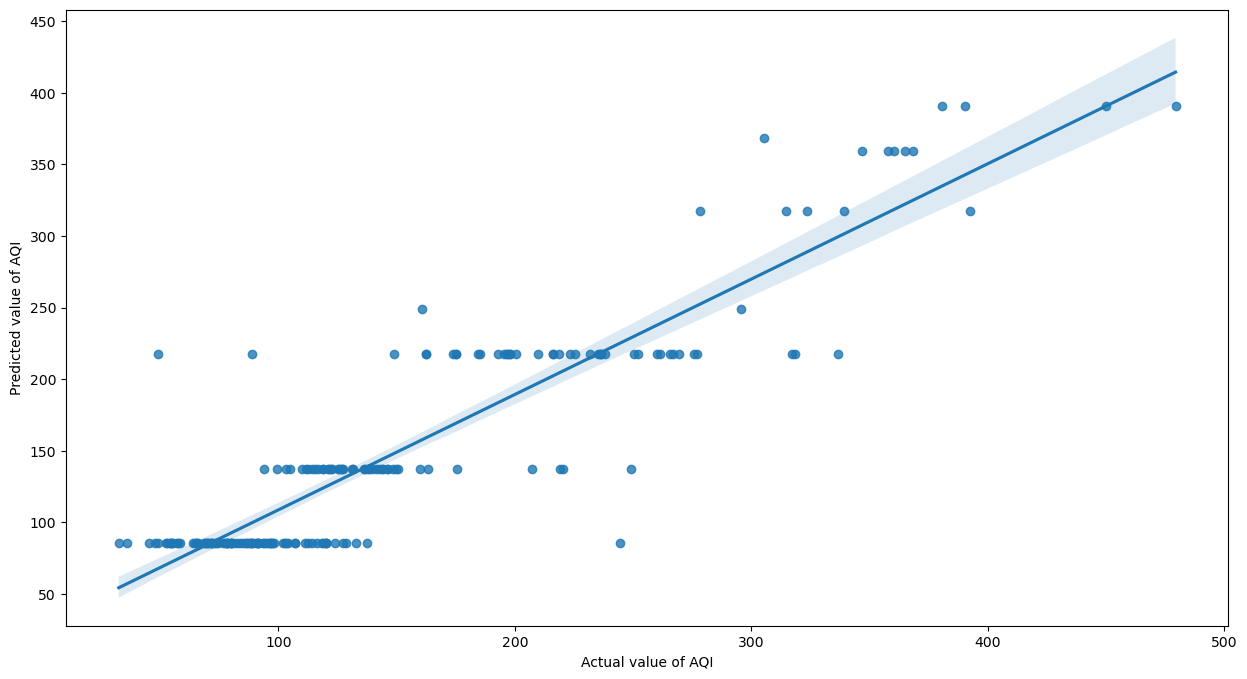

In [47]:
sns.regplot(y_test,y_pred2)
plt.xlabel('Actual value of AQI')
plt.ylabel('Predicted value of AQI')


# Comparison

<AxesSubplot:>

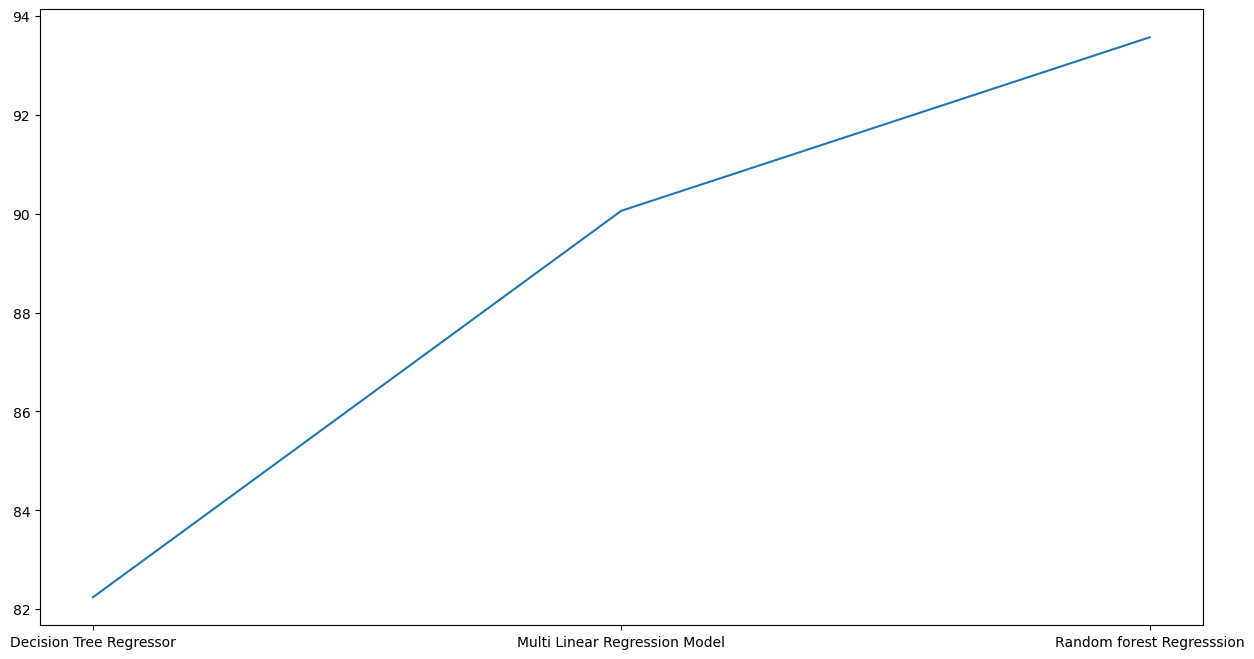

In [48]:
a=["Decision Tree Regressor","Multi Linear Regression Model","Random forest Regresssion"]
b=[82.24,90.06,93.57]
sns.lineplot(a,b)

# CONCLUSIONS

* We have done a Multivariate analysis on AQI.
* We have recieved the best results for predicting AQI through random forest regression, therefore we chose Choose as our final model and the forecasted values are visualized through graphical representation.
* From the forecasted graph we can conclude that AQI will be high for coming years. The focus should be on how the pollutants affecting AQI can be reduced.
* According to our analysis the pollutants affecting the most on AQI are PM2.5, NO2 and CO on the basis of Correlation and Statistical Analysis.